# Classifiez automatiquement des biens de consommation

This notebook encompass a whole project on NLP and computer vision. 
We are working for a marketplace where individuals buyers and sellers meet to transact on any product. The ultimate purpose is to create an algorithm that automatically classify a good thanks to a picture and a short description text, to ease both the processes of selling and buying a product, through automated and precise classification/labelling.

We are going to study the feasibility of such algorithm with the data at our disposal.

This notebook is devised in two main parts :  
  * Text classsification 
  * Images classification
    

# Text classification 

## General data preparation

In [2]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [3]:
# Style
font_perso = {'family': 'serif',
              'color':  'k',
              'size': 18,
             }

sns.set_style("darkgrid")

pd.options.display.float_format = '{:,.2f}'.format

In [4]:
# Loading data
raw_text = pd.read_csv(r"./Dataset_projet_pretraitement_textes_images/Flipkart/flipkart_com-ecommerce_sample_1050.csv", sep = ',', low_memory = False)

In [5]:
# Shape and types
print(raw_text.shape)
print(raw_text.dtypes)

(1050, 15)
uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object


In [6]:
# Head
raw_text.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,"1,899.00",899.00,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.00,449.00,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,"2,699.00","1,299.00",d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,"2,599.00",698.00,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


<AxesSubplot:>

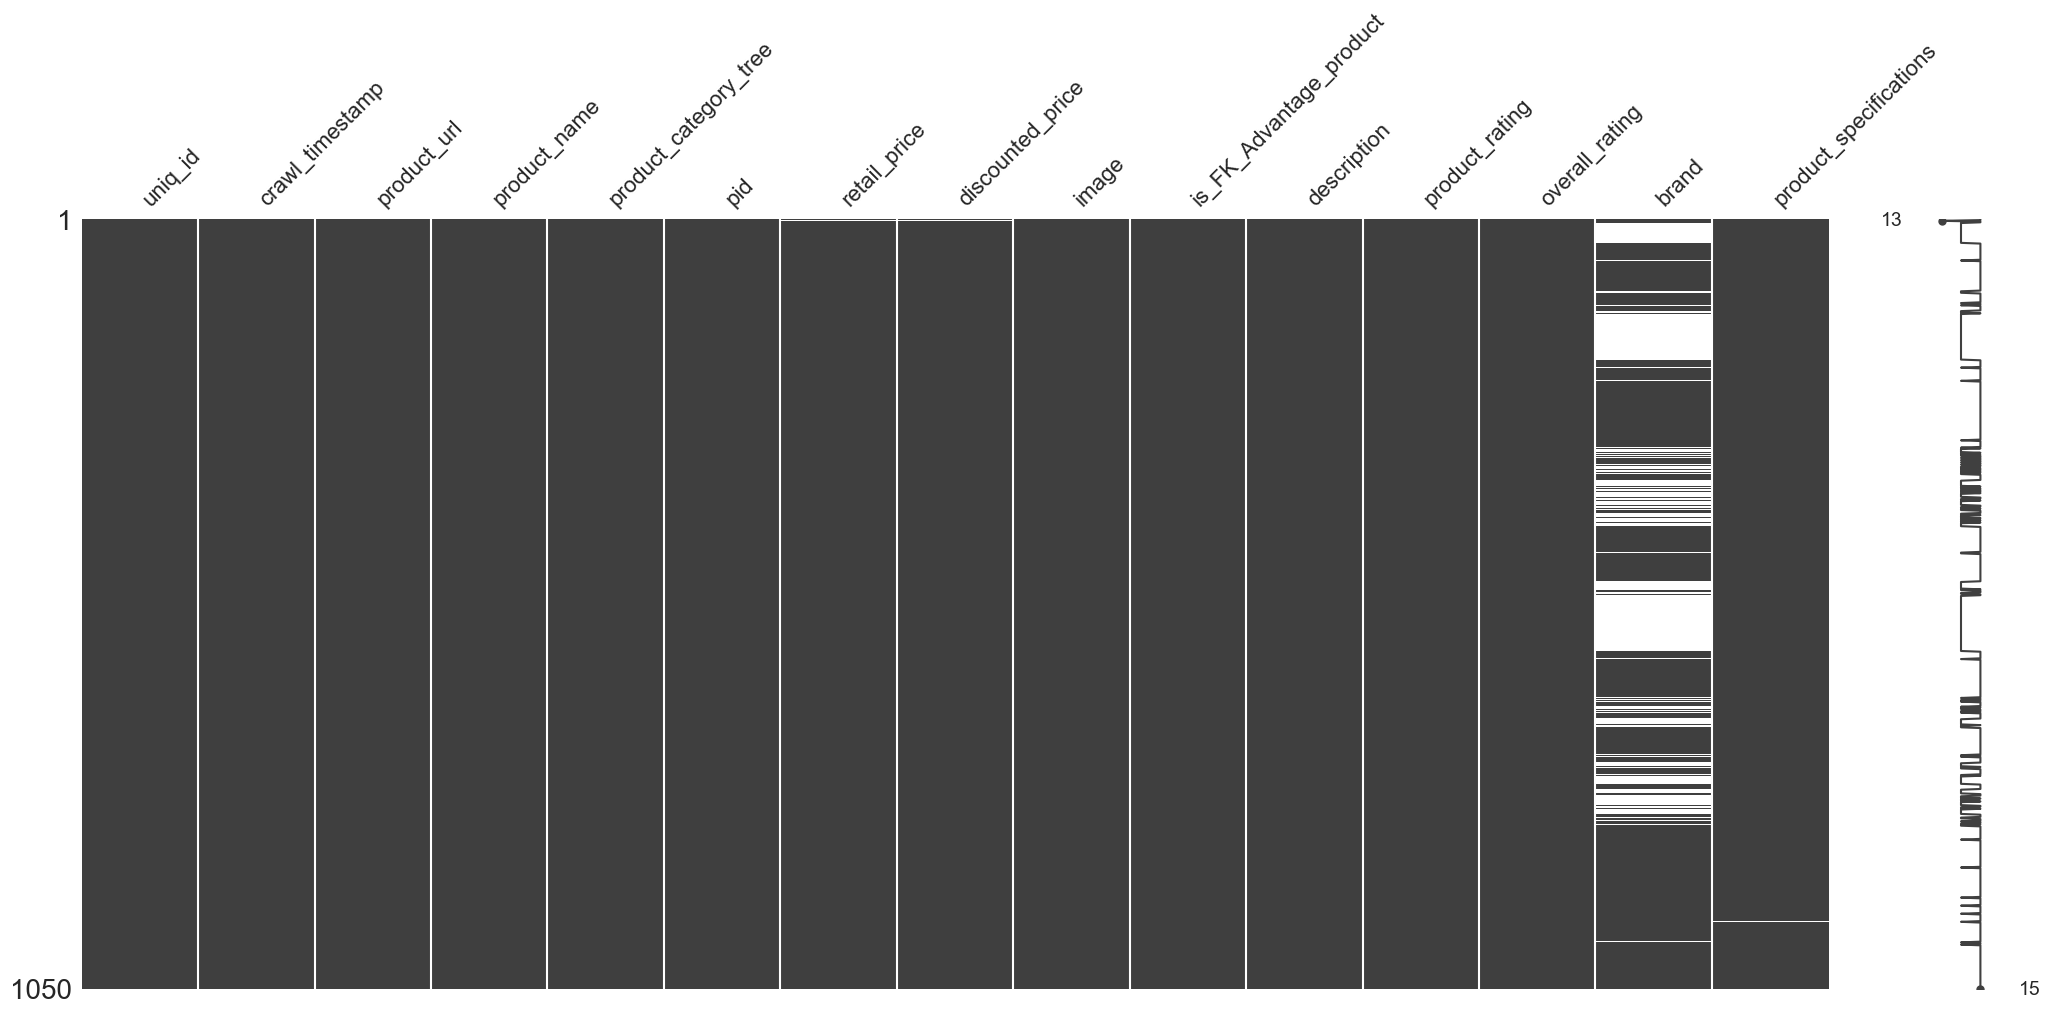

In [7]:
#Missing values
%matplotlib inline
msno.matrix(raw_text)

The dataset looks very complete except for the brand column, but this is not too much of a drawback for our mission.

For the first part of the project (text-based classification) the variables of interest are 'product_name', 'product_category_tree', and 'description'.

In [8]:
# Category exploration
raw_text.iloc[0,4]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [9]:
pd.options.display.max_colwidth=1000
raw_text.iloc[0,4]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [10]:
pd.options.display.max_colwidth=50

It seems that we don't have the full text of product categories, but it might suffice.

In [11]:
### Categories reformating functions
def split_categories(category, level):
    category = category.split('["')[1].split('"]')[0]
    cat = category.split(' >> ')
    if(len(cat)) < 3:
        cat = [cat[0], cat[1], 'None']
        if(len(cat))<2:
            cat = [cat[0], 'None', 'None']
    return cat[level]

def split_categories_1(category):
    return split_categories(category,0)
def split_categories_2(category):
    return split_categories(category,1)
def split_categories_3(category):
    return split_categories(category,2)

def detail_categories(dataframe):
    dataframe['cat_lvl_1'] = dataframe['product_category_tree'].apply(split_categories_1)
    dataframe['cat_lvl_2'] = dataframe['product_category_tree'].apply(split_categories_2)
    dataframe['cat_lvl_3'] = dataframe['product_category_tree'].apply(split_categories_3)
    return dataframe.drop(['product_category_tree'], axis=1)

In [12]:
# Cat reformating
raw_text = detail_categories(raw_text)

In [13]:
raw_text.head()

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,cat_lvl_1,cat_lvl_2,cat_lvl_3
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,CRNEG7BKMFFYHQ8Z,"1,899.00",899.00,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,Curtains
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,BTWEGFZHGBXPHZUH,600.00,449.00,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,Baby Bath Towels
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,Baby Bath Towels
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,BDSEJT9UQWHDUBH4,"2,699.00","1,299.00",d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,Bedsheets
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,BDSEJTHNGWVGWWQU,"2,599.00",698.00,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,Bedsheets


In [14]:
# Categories exploration
raw_text['cat_lvl_1'].unique() 

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

8 categories is a too few. Let's check the second level

In [15]:
raw_text['cat_lvl_2'].unique() 

array(['Curtains & Accessories', 'Baby Bath & Skin', 'Bed Linen',
       'Wrist Watches', 'Living Room Furnishing', 'Bath Linen',
       'Candles & Fragrances', 'Tableware & Cutlery', 'Lighting',
       'JMD Home Furnishing', 'Infant Wear', "Kripa's Home Furnishing",
       'Hair Care', 'Coffee Mugs', 'Network Components',
       'Tablet Accessories', 'Cookware', 'Laptop Accessories', 'Makeup',
       'Combos and Kits', 'Feeding & Nursing', 'Baby Bedding',
       'Kitchen & Dining Linen', 'Containers & Bottles',
       'Consumables & Disposables', 'Wall Decor & Clocks',
       'Table Decor & Handicrafts', 'Flowers, Plants & Vases', 'Software',
       'Showpieces', 'Furniture & Furnishings',
       'Decorative Lighting & Lamps', 'Baby Grooming',
       'Computer Peripherals', 'Cushions, Pillows & Covers', 'Storage',
       'Health Care', 'Body and Skin Care', 'Kitchen Tools',
       'TRUE Home Decor & Festive Needs', 'Living', 'Showpiece',
       'Bar & Glassware', 'Fragrances', "Women'

This looks better. We are going to use the second level as labelling variable.

In [16]:
l_cat = list(set(raw_text['cat_lvl_2']))
y_cat_num = [(1-l_cat.index(raw_text.iloc[i]['cat_lvl_2'])) for i in range(len(raw_text))]

In [17]:
data_text = raw_text[['uniq_id', 'product_name', 'image', 'description', 'cat_lvl_1', 'cat_lvl_2', 'cat_lvl_3']]

## Text cleaning

First, we define the cleaning functions we are going to use with each method.

In [18]:
# Tokenizer
import nltk
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('  ', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['-', '+', '/', '#', '[', ']', ',', '.', ':', '?', '(', ')', 'Key', "key", "Features", "features", "Specifications", "specifications", "a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#   sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\grege\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Cleaning
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Deleting numbers
import re
def clean_nb(text):
    text_nonum = re.sub(r'\d+', '', text)
    return text_nonum

tknzd_text = data_text

tknzd_text['description'] = tknzd_text['description'].apply(lambda x : clean_nb(x))

tknzd_text['sentence_bow'] = tknzd_text['description'].apply(lambda x : transform_bow_fct(x))
tknzd_text['sentence_bow_lem'] = tknzd_text['description'].apply(lambda x : transform_bow_lem_fct(x))
tknzd_text['sentence_dl'] = tknzd_text['description'].apply(lambda x : transform_dl_fct(x))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\grege\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\grege\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\grege\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
C:\Users\grege\AppData\Local\Temp\ipykernel_12676\4156595439.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tknzd_text['description'] = tknzd_text['description'].apply(lambda x : clean_nb(x))
C:\Users\grege\AppData\Local\Temp\ipykernel_12676\4156595439.py:16: SettingWithCopyWarning: 
A

In [20]:
tknzd_text.head()

,uniq_id,product_name,image,description,cat_lvl_1,cat_lvl_2,cat_lvl_3,sentence_bow,sentence_bow_lem,sentence_dl
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,Curtains & Accessories,Curtains,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...,key features of elegance polyester multicolor ...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,Baby Bath & Skin,Baby Bath Towels,sathiyas cotton bath towel bath towel red yell...,sathiyas cotton bath towel bath towel red yell...,specifications of sathiyas cotton bath towel (...
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,Baby Bath & Skin,Baby Bath Towels,eurospa cotton terry face towel set size small...,eurospa cotton terry face towel set size small...,key features of eurospa cotton terry face towe...
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,Bed Linen,Bedsheets,santosh royal fashion cotton printed king size...,santosh royal fashion cotton printed king size...,key features of santosh royal fashion cotton p...
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,Bed Linen,Bedsheets,jaipur print cotton floral king sized double b...,jaipur print cotton floral king sized double b...,key features of jaipur print cotton floral kin...


After having removed all stopwords and punctuation, we also filtered-out the reccuring intro words: "key" "features" and "specifications". On the other hand, we kept in the description the name of the product because it includes the brand and sometimes the range/collection of the products, which may significantly help the classification procedure.

Let verify that there aren't any other too recurring and uninformative words.

In [21]:
# Frequence of a unique word in a given column
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tknzd_text['sentence_bow_lem'])
freq = np.ravel(X.sum(axis=0))

import operator
# get vocabulary keys, sorted by value
vocab = [v[0] for v in sorted(vectorizer.vocabulary_.items(),     key=operator.itemgetter(1))]
fdist = dict(zip(vocab, sorted(freq, reverse=True))) # return same format as nltk

fdist

{'_blk': 864,
 'aaa': 720,
 'aapno': 618,
 'aari': 611,
 'aarika': 581,
 'ability': 567,
 'abkl_grn_grn_grn': 564,
 'abkl_pl_pl_pnk': 564,
 'abkl_pl_pnk_pnk': 564,
 'abode': 559,
 'about': 558,
 'abrasion': 553,
 'abroad': 481,
 'absolute': 473,
 'absorbency': 471,
 'absorbent': 457,
 'absorber': 396,
 'absorbing': 367,
 'absorbs': 355,
 'abstract': 354,
 'abstrcts': 325,
 'accent': 321,
 'access': 319,
 'accessory': 313,
 'accident': 312,
 'accidental': 299,
 'accommodate': 297,
 'accomplishes': 288,
 'according': 271,
 'acer': 269,
 'ache': 262,
 'aching': 262,
 'aci': 254,
 'acid': 252,
 'acl': 245,
 'acne': 243,
 'acrylic': 242,
 'act': 239,
 'active': 238,
 'actu': 234,
 'actual': 226,
 'actx': 219,
 'acu': 211,
 'adaa': 207,
 'adapter': 196,
 'adaptor': 190,
 'add': 189,
 'added': 189,
 'addiction': 184,
 'adding': 184,
 'addition': 183,
 'additional': 180,
 'additionally': 177,
 'adf': 177,
 'adhesive': 175,
 'adi': 174,
 'adidas': 170,
 'adino': 167,
 'adjust': 165,
 'adjustabl

In [22]:
tknzd_text['length_bow'] = tknzd_text['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", tknzd_text['length_bow'].max())

tknzd_text['length_bow_lem'] = tknzd_text['sentence_bow_lem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow_lem : ", tknzd_text['length_bow_lem'].max())

tknzd_text['length_dl'] = tknzd_text['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", tknzd_text['length_dl'].max())

C:\Users\grege\AppData\Local\Temp\ipykernel_12676\381122265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tknzd_text['length_bow'] = tknzd_text['sentence_bow'].apply(lambda x : len(word_tokenize(x)))


max length bow :  354


C:\Users\grege\AppData\Local\Temp\ipykernel_12676\381122265.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tknzd_text['length_bow_lem'] = tknzd_text['sentence_bow_lem'].apply(lambda x : len(word_tokenize(x)))


max length bow_lem :  354
max length dl :  622


C:\Users\grege\AppData\Local\Temp\ipykernel_12676\381122265.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tknzd_text['length_dl'] = tknzd_text['sentence_dl'].apply(lambda x : len(word_tokenize(x)))


Now that the cleaning is ok, let's switch to the classification.

## Models 

In [23]:
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition

### Dimension reduction functions

First, we are going to create dimension reduction functions as well as ARI scores functions to visualize and asses the performance of our clustering models.

In [24]:
# Tsne perplexity calculation (from https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868)
perp_ = pow(tknzd_text.shape[0], (1/2))

In [25]:
# Function that calculates Tsne, determines clusters and compute ARIscore between real categories and clustering results
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=15, n_iter=2000,  # after different tests, 15 is the best perplexity
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Clusters after Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# Visualisation of Tsne's clustering results vs real categories:
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Real categories representation')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Tsne clustering representation')
    
    plt.show()
    print("ARI : ", ARI)


### Bag of word - Tf-idf

In [25]:
# Bag of words creation (CountVectorizer & Tf-idf)

from sklearn.feature_extraction.text import TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(tknzd_text[feat])
ctf_fit = ctf.fit(tknzd_text[feat])

cv_transform = cvect.transform(tknzd_text[feat])  
ctf_transform = ctf.transform(tknzd_text[feat])  

In [26]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

CountVectorizer : 
-----------------
ARI :  0.2967 time :  7.0

Tf-idf : 
--------
ARI :  0.315 time :  6.0


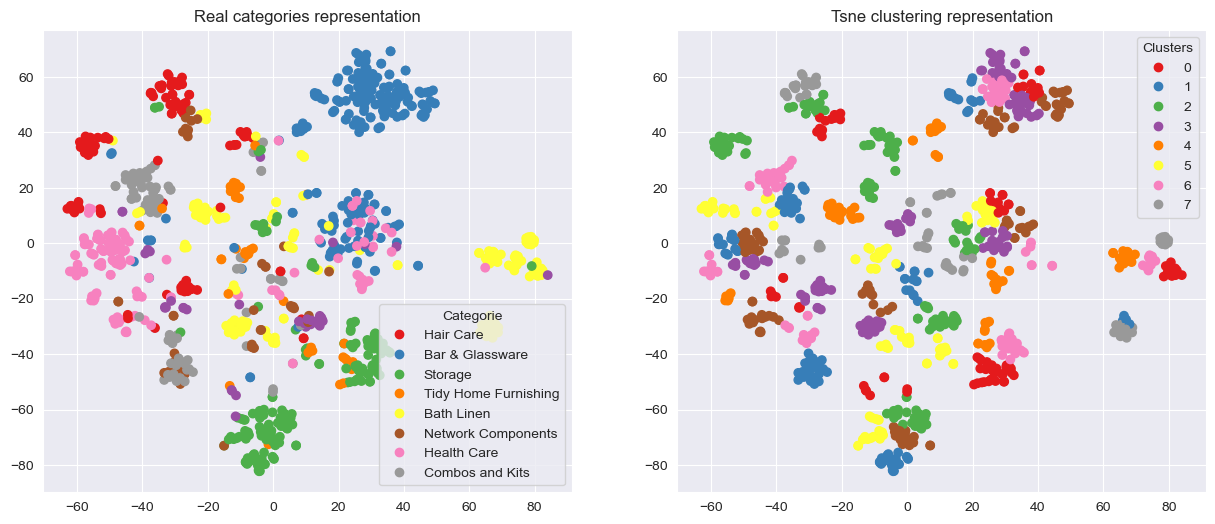

ARI :  0.315


In [27]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

The ARI score is relatively low, but we have a very small dataset. Let's see if more complex techniques give better results.

### Word2Vec

In [28]:
import tensorflow as tf
import tensorflow.keras
import multiprocess
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [29]:
# Preparation Word2Vec
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
#maxlen = 200
sentences = tknzd_text['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [30]:
# Training the model
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=multiprocess.cpu_count())

w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4592
Word2Vec trained


In [31]:
# Sentences prep (tokenization)
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                    # maxlen=None, removed to use the length of longest sentence by default
                                                     padding='post') 
x_length = x_sentences.shape[1] # record of the width of the array (nb of columns)                                                 
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4593


In [32]:
x_sentences.shape[1] 

352

In [33]:
# Embedding matrix creation
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4593, 300)


In [34]:
# Embedding model
input=Input(shape=(len(x_sentences),x_length),dtype='float64')
word_input=Input(shape=(x_length,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=x_length)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 352)]             0         
                                                                 
 embedding (Embedding)       (None, 352, 300)          1377900   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,377,900
Trainable params: 1,377,900
Non-trainable params: 0
_________________________________________________________________


In [35]:
#Running the model
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 2ms/step


(1050, 300)

In [36]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.2883 time :  6.0


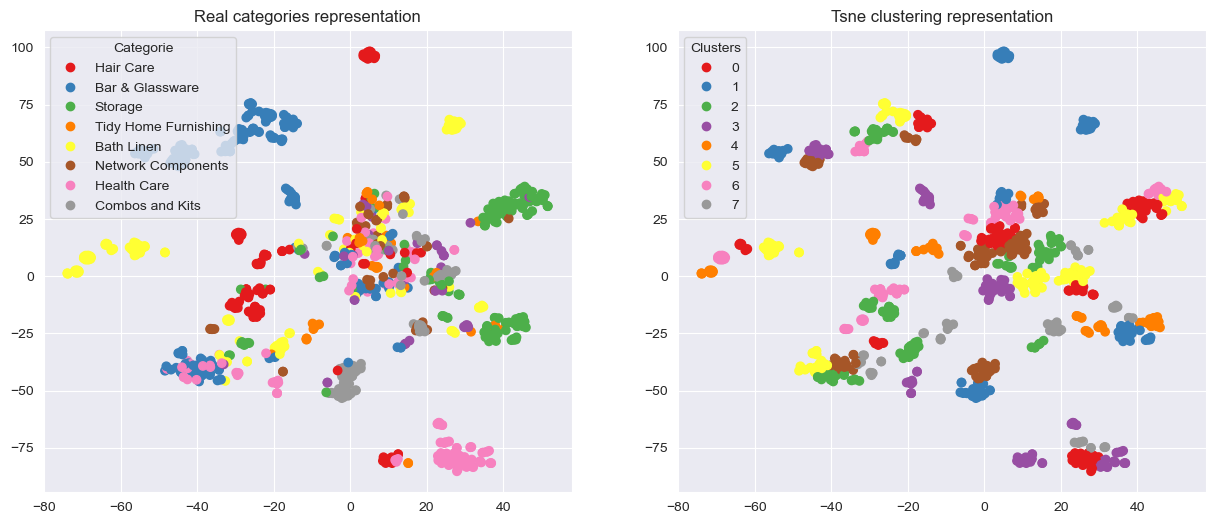

ARI :  0.2883


In [37]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

As with Tf-idf, the Word2Vec model fails quite a lot in being the source of cluster definition.

### BERT

In [38]:
# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [39]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
False


In [40]:
# Sentences preparation function
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Features creation function
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

#### BERT HuggingFace

In [41]:
#max_length = x_length
#batch_size = 105
#model_type = 'bert-base-uncased'
#model = TFAutoModel.from_pretrained(model_type)
#sentences = tknzd_text['sentence_dl'].to_list()

loading configuration file config.json from cache at C:\Users\grege/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at C:\Users\grege/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb42

In [42]:
# Features creation
#features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
#                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at C:\Users\grege/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\grege/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.t

1/1 [==============================] - 29s 29s/step
temps traitement :  294.0


In [43]:
#ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.2521 time :  7.0


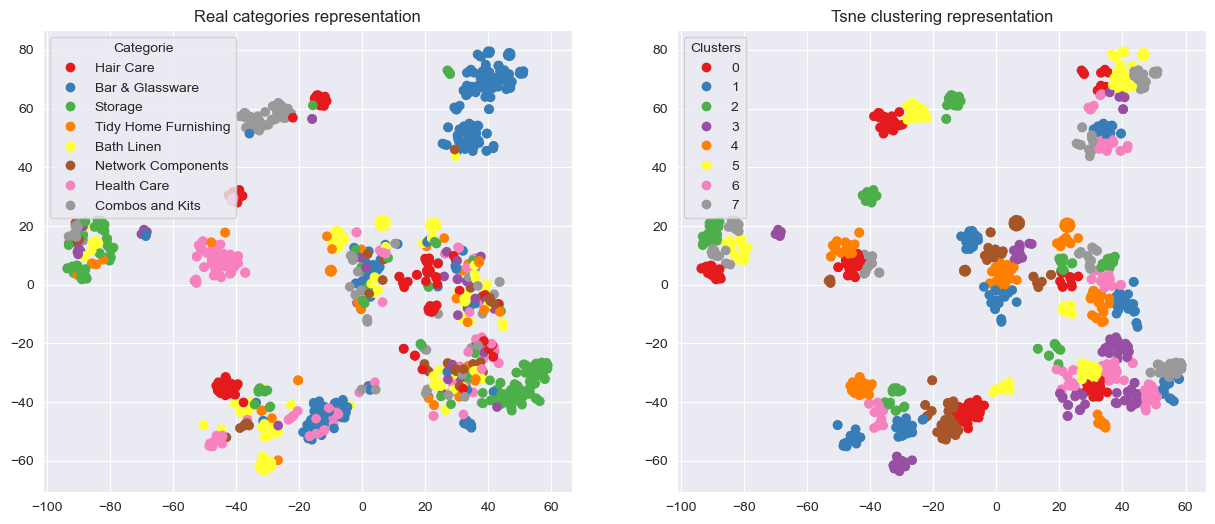

ARI :  0.2521


In [44]:
#TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

#### BERT hub Tensorflow

In [45]:
#import tensorflow_hub as hub
#model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
#bert_layer = hub.KerasLayer(model_url, trainable=True)

In [46]:
#sentences = tknzd_text['sentence_dl'].to_list()

In [47]:
#max_length = 64
#batch_size = 10
#model_type = 'bert-base-uncased'
#model = bert_layer
#
#features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
#                                                         max_length, batch_size, mode='TFhub')

loading configuration file config.json from cache at C:\Users\grege/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\grege/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.t

temps traitement :  54.0


In [48]:
#ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.2745 time :  8.0


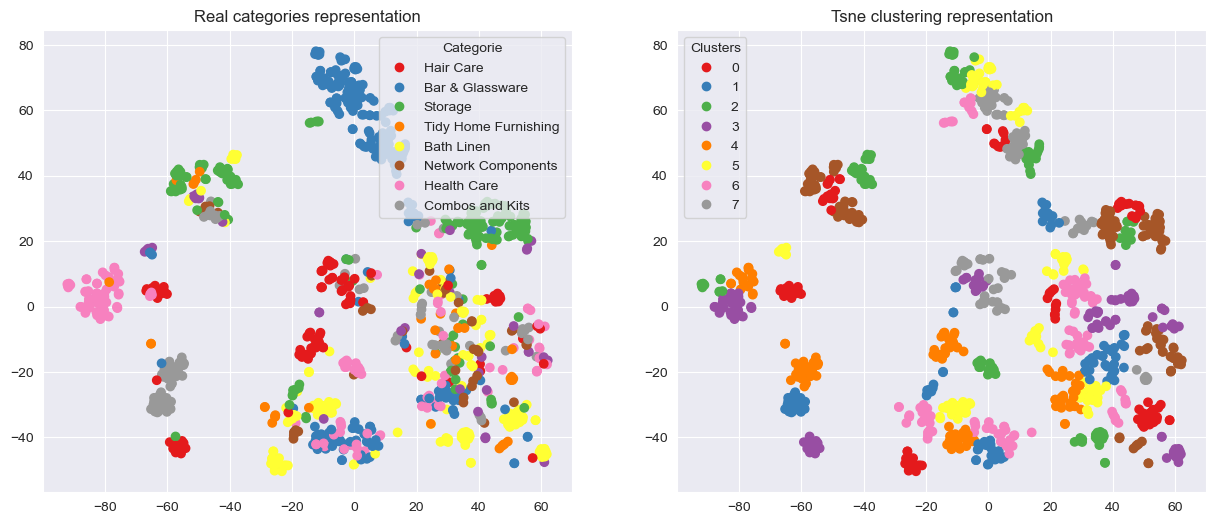

ARI :  0.2745


In [49]:
#TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Universal Sentence Encoder (USE)

In [50]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [51]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
False


In [52]:
# Loading the USE model
import tensorflow_hub as hub
import time

start = time.time()
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
end = time.time()
duration = end - start
print(duration)

10.983167171478271


In [53]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [54]:
batch_size = 10
sentences = tknzd_text['sentence_dl'].to_list()

In [55]:
features_USE = feature_USE_fct(sentences, batch_size)

In [56]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.3004 time :  7.0


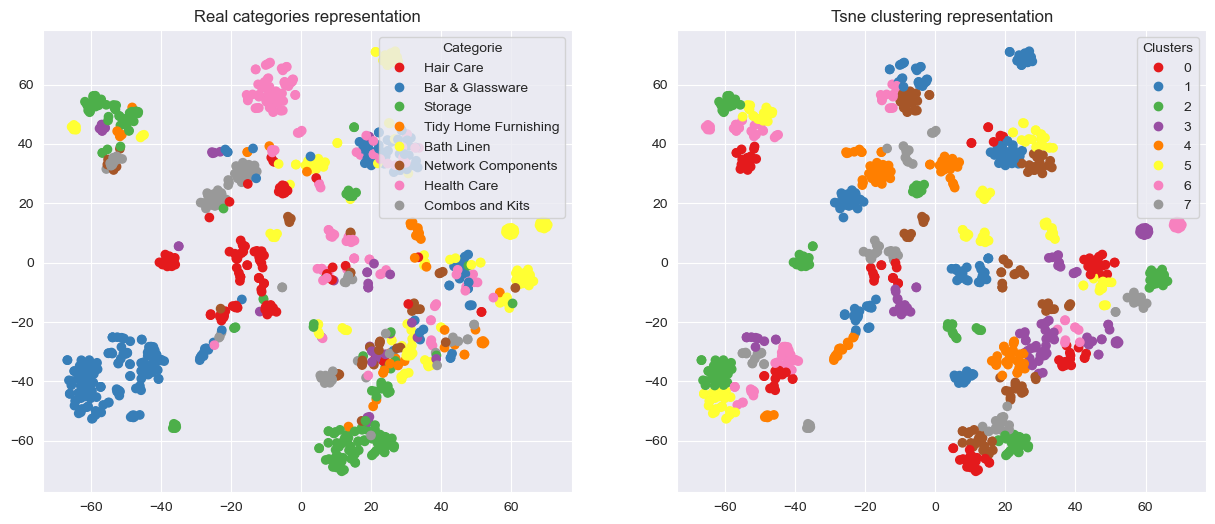

ARI :  0.3004


In [57]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

It looks quite disappointing as the tf-idf is the best model with a 0.315 ARI score, followed by the USE with 0.300.
All the t-sne representations show that the different models fail in predicting item categories.

Moreover, we did not even split the dataset in a training + test set, which reinforce the concerning results.

We are now going to see if image clustering performs better.

## Image classification

### Preparation

In [58]:
# Loading the iamges
from os import listdir

path = r"./Dataset_projet_pretraitement_textes_images/Flipkart/Images/"
list_photos = [file for file in listdir(path) if file.endswith('.jpg')]
print(len(list_photos))

1050


In [59]:
list_photos

['009099b1f6e1e8f893ec29a7023153c4.jpg',
 '0096e89cc25a8b96fb9808716406fe94.jpg',
 '00cbbc837d340fa163d11e169fbdb952.jpg',
 '00d84a518e0550612fcfcba3b02b6255.jpg',
 '00e966a5049a262cfc72e6bbf68b80e7.jpg',
 '00ed03657cedbe4663eff2d7fa702a33.jpg',
 '01089dc3618a0ab7304d784ef400b83d.jpg',
 '0131e5d87b72877702d536299cf83b75.jpg',
 '020d2daba55a723128e4e07c0b0393a9.jpg',
 '02127f52e96fb72c66bf081d25104ef8.jpg',
 '025a85a3d1cddc6307f7dc075d8d2132.jpg',
 '02a53d335775b652f22f41b529b9d646.jpg',
 '02c63a087b298ec74042d557acf61be1.jpg',
 '031c98cfde349d99fb6d5983f54c8751.jpg',
 '032e812adcd11a38fd8b764891a852ff.jpg',
 '037b39bef3db7ccd264c577a0edf0c0a.jpg',
 '037c2402fee39fbc80433935711d1383.jpg',
 '04f9f818e2d657b873b07578cfe2eade.jpg',
 '04f9ff160a1561e3656350f4bd6b8c50.jpg',
 '050ea3acb555bf641e7ae9b4f3ba684a.jpg',
 '052559ede419996737893eb47568ee7f.jpg',
 '057836ecde71565f8ebdd576e41fdc96.jpg',
 '059493eeb88ebb4cc08d1522f3f87c3f.jpg',
 '059bc43e03e1824a9ab6466e32e5f137.jpg',
 '06749cbff1487f

In [60]:
# Gathering photos labels
from sklearn import preprocessing

data = tknzd_text[["uniq_id", "image", "cat_lvl_1"]]
data.rename(columns={"image" : "image_path",
                     "cat_lvl_1" : "label_name"}, inplace = True)

le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["label_name"])
data

C:\Users\grege\AppData\Local\Temp\ipykernel_9300\187814506.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={"image" : "image_path",
C:\Users\grege\AppData\Local\Temp\ipykernel_9300\187814506.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["label"] = le.fit_transform(data["label_name"])


,uniq_id,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


In [61]:
tknzd_text.groupby('cat_lvl_2').count()

,uniq_id,product_name,image,description,cat_lvl_1,cat_lvl_3,sentence_bow,sentence_bow_lem,sentence_dl,length_bow,length_bow_lem,length_dl
cat_lvl_2,,,,,,,,,,,,
Baby & Kids Gifts,15,15,15,15,15,15,15,15,15,15,15,15
Baby Bath & Skin,14,14,14,14,14,14,14,14,14,14,14,14
Baby Bedding,15,15,15,15,15,15,15,15,15,15,15,15
Baby Grooming,4,4,4,4,4,4,4,4,4,4,4,4
Bar & Glassware,8,8,8,8,8,8,8,8,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...
Tableware & Cutlery,3,3,3,3,3,3,3,3,3,3,3,3
Tidy Home Furnishing,1,1,1,1,1,1,1,1,1,1,1,1
Wall Decor & Clocks,22,22,22,22,22,22,22,22,22,22,22,22


In [62]:
data.groupby("label").count()

,uniq_id,image_path,label_name
label,,,
0,150,150,150
1,150,150,150
2,150,150,150
3,150,150,150
4,150,150,150
5,150,150,150
6,150,150,150


We see that each category contains the same number of products, which is good for modeling purposes.

In [63]:
list_labels = data["label_name"].unique()
list_labels

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

### ORB modelisation


In [64]:
path = r"./Dataset_projet_pretraitement_textes_images/Flipkart/Images/"

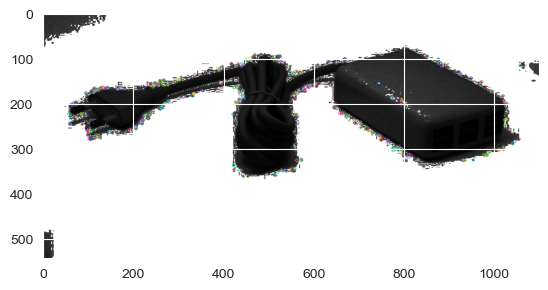

Descriptors :  (500, 32)

[[106  50 247 ... 132 102 245]
 [154   9 114 ... 136  48   8]
 [ 18 248 230 ... 132 165  93]
 ...
 [242 168 198 ... 168 210 136]
 [ 54  44 246 ... 107 241 128]
 [130  44 246 ... 200 225 141]]


In [65]:
# Load a photo as example
import cv2

image = cv2.imread(path + list_photos[6], 0) # The 0 right here load the photo and convert it to black and white.
image = cv2.equalizeHist(image)   # equalize image histogram

# Initiate ORB detector
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors
keypoints = orb.detect(image, None)
keypoints, descriptors = orb.compute(image, keypoints)

# Display the keypoints locations
img=cv2.drawKeypoints(image, keypoints, image)
plt.imshow(img)
plt.show()
print("Descriptors : ", descriptors.shape)
print()
print(descriptors)

In [66]:
#Identification of key points and associated descriptors
import time
orb_keypoints = []
temps1 = time.time()
orb = cv2.ORB_create(500)

for image_num in range(len(list_photos)) :
    image = cv2.imread(path + list_photos[image_num], 0) 
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp = orb.detect(res, None)
    kp, des = orb.compute(res, kp)
    orb_keypoints.append(des)
    
orb_keypoints_by_img = np.asarray(orb_keypoints)
orb_keypoints_all    = np.concatenate(orb_keypoints_by_img, axis=0)

print()
print("Number of descriptors : ", orb_keypoints_all.shape)

duration1=time.time()-temps1
print("ORB descriptor training time: ", "%15.2f" % duration1, "secondes")


Number of descriptors :  (520145, 32)
ORB descriptor training time:            41.10 secondes


C:\Users\grege\AppData\Local\Temp\ipykernel_9300\2353560573.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  orb_keypoints_by_img = np.asarray(orb_keypoints)


In [67]:
# Cluster creation
from sklearn import cluster, metrics

# Determination number of clusters
start = time.time()

k = int(round(np.sqrt(len(orb_keypoints_all)),0)) # One way of selecting k: square root of numbert of descriptor (max nb) or we could do 10x number of categories (7) which would make 70 clusters - (min nb).
print("Number of estimated k : ", k)
print("Creation of",k, "clusters of descriptors ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(orb_keypoints_all)

end = time.time()
duration = end-start
print("Kmeans training time : ", "%15.2f" % duration, "seconds")

Number of estimated k :  721
Creation of 721 clusters of descriptors ...
Kmeans training time :             3.96 seconds


In [68]:
# Creation of histograms (features)
start=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("histogramme image problem : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(orb_keypoints_by_img) :
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

end = time.time()
duration = end - start
print("Histograms creation time : ", "%15.2f" % duration, "seconds")


Histograms creation time :            59.49 seconds


### T-SNE dimensionality reduction

In [69]:
from sklearn import manifold, decomposition

# We first use a PCA to improve T-SNE and its training time
print("Dimension of dataset before PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimension of dataset after PCA : ", feat_pca.shape)


# Second, we run a T-SNE with to the PCA results
# Tsne perplexity calculation (from https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868)
perp_ = pow(feat_pca.shape[0], (1/2))

tsne = manifold.TSNE(n_components=2, perplexity=perp_, 
                     n_iter=2000, init='random')
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]
print(df_tsne.shape)

Dimension of dataset before PCA :  (1050, 721)
Dimension of dataset after PCA :  (1050, 579)


C:\Users\grege\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


In [70]:
# Clusters creation with T-SNE
cls = cluster.KMeans(n_clusters=7)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


In [71]:
# Calculation of the ARI Score
label = data["label"]
ARI = metrics.adjusted_rand_score(label, cls.labels_)
print("The ARI score is: ", ARI)

The ARI score is:  5.031904511934097e-05


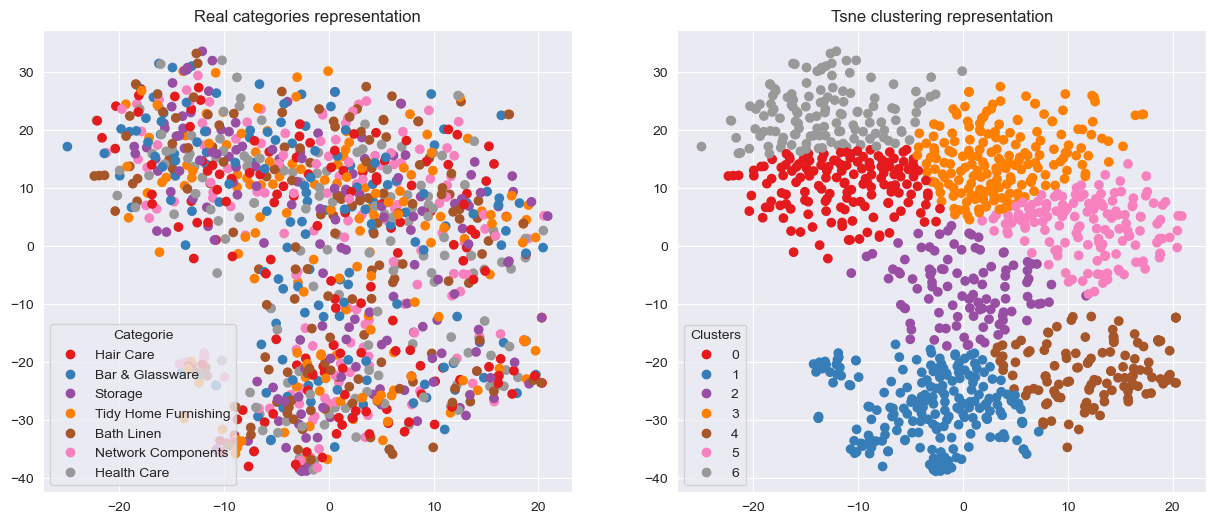

ARI :  5.031904511934097e-05


In [72]:
# Representation of the clustering (poor) results
TSNE_visu_fct(X_tsne, label, cls.labels_, ARI)

We see that a T-SNE is having hard times with the real categories, and the clustering too (ARI = 0.0005). Because the ARI Score is heavily penalized by dissimilarities results, we are going to compute the confusion matrix.

In [73]:
# Confusion matrix creation (1/4)
df_tsne.groupby("cluster").count()["class"]

cluster
0    150
1    212
2    103
3    185
4    125
5    144
6    131
Name: class, dtype: int64

In [74]:
# Confusion matrix creation (2/4)
conf_mat = metrics.confusion_matrix(y_true = label, y_pred = cls.labels_)
print(conf_mat)

[[24 38 12 25 21 17 13]
 [21 23 17 28 15 18 28]
 [23 25 13 19 22 23 25]
 [23 33 13 26 16 22 17]
 [17 35 18 32 13 18 17]
 [17 31 17 33 15 21 16]
 [25 27 13 22 23 25 15]]


In [75]:
# Confusion matrix creation (3/4)
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    
    corresp = np.argmax(conf_mat, axis=0) # because we have bad/contradicting results, we cannot produce a proper confusion matrix. So we use argmax, considering we performed. But that is wrong as we can see in "Clusters correspondance"
    print ("Clusters correspondance : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(label, cls.labels_)
conf_mat = metrics.confusion_matrix(label, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(label, cls_labels_transform, zero_division =0))

Clusters correspondance :  [6 0 4 5 6 6 1]
[[38 13  0  0 12 25 62]
 [23 28  0  0 17 28 54]
 [25 25  0  0 13 19 68]
 [33 17  0  0 13 26 61]
 [35 17  0  0 18 32 48]
 [31 16  0  0 17 33 53]
 [27 15  0  0 13 22 73]]

              precision    recall  f1-score   support

           0       0.18      0.25      0.21       150
           1       0.21      0.19      0.20       150
           2       0.00      0.00      0.00       150
           3       0.00      0.00      0.00       150
           4       0.17      0.12      0.14       150
           5       0.18      0.22      0.20       150
           6       0.17      0.49      0.26       150

    accuracy                           0.18      1050
   macro avg       0.13      0.18      0.14      1050
weighted avg       0.13      0.18      0.14      1050



<AxesSubplot:>

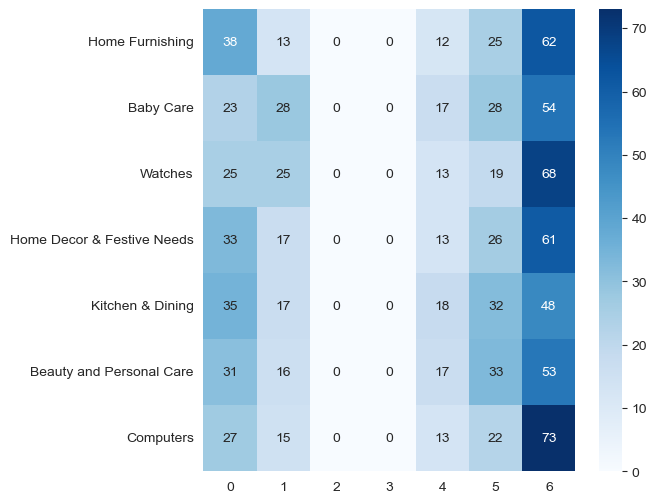

In [76]:
# Confusion matrix creation (4/4)
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,6))
sns.heatmap(df_cm, annot=True, cmap="Blues")

The results are not interpretable as we see that we have not the right clusters labelization (5 0 2 0 5 3 4). I still don't found a way to properly label the results of the confusion matrix, but the ARI score is so bad that it's not really usefull to implement it anyway.

### CNN Transfer  Learning

We are going to use the VGG Net model, with 16 layers. Most importantly, we are not going to train it because our sample is too small (1050), and our computation power not sufficient for such a project (faesibility assessment)

#### Preparation

In [42]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
import cv2

# Files
path = r"./Dataset_projet_pretraitement_textes_images/Flipkart/Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

# Gathering photos labels
from sklearn import preprocessing

data = tknzd_text[["uniq_id", "image", "cat_lvl_1"]]
data.rename(columns={"image" : "image_path",
                     "cat_lvl_1" : "label_name"}, inplace = True)

le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["label_name"])
data

1058


C:\Users\grege\AppData\Local\Temp\ipykernel_12676\222961667.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={"image" : "image_path",
C:\Users\grege\AppData\Local\Temp\ipykernel_12676\222961667.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["label"] = le.fit_transform(data["label_name"])


,uniq_id,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


### VGG16 with a fully pre-trained implementation

In [43]:
from keras import Model
from keras.layers import Dense
from keras.layers import Flatten

In [44]:
import tensorflow as tf
import tensorflow.keras
import multiprocess

from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [45]:
images = data["image_path"].tolist()

In [47]:
from tensorflow.keras.utils import load_img
from keras.utils.image_utils import img_to_array
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from pickle import dump

# Preprocessing the images with a full Keras implementation 
preprocessed_images = []

for i in images:
  load = load_img(path+str(i), target_size=(224, 224))
  img = img_to_array(load)
  reshape = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
  preprocessed = preprocess_input(reshape)
  preprocessed_images.append(preprocessed)

In [48]:
# Redefining the model with the fully pre-trained features
model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Predicting eacg image category
features_vgg16 = np.zeros((1, 4096))

for i in preprocessed_images:
  features = model.predict(i)
  features_vgg16 = np.append(features_vgg16, features, axis=0)

features_vgg16 = np.delete(features_vgg16, 0, 0)

1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 152ms/step


In [81]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [82]:
# Associating classes to labels in a dict
classes = le.classes_
values = le.transform(le.classes_)
dict_classes = dict(zip(classes, values))
print(dict_classes)

{'Baby Care': 0, 'Beauty and Personal Care': 1, 'Computers': 2, 'Home Decor & Festive Needs': 3, 'Home Furnishing': 4, 'Kitchen & Dining': 5, 'Watches': 6}


In [83]:
from sklearn import manifold, decomposition
# We first use a PCA to improve T-SNE and its training time
print("Dimension of dataset before PCA : ", features_vgg16.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(features_vgg16)
print("Dimension of dataset after PCA : ", feat_pca.shape)


# Second, we run a T-SNE with to the PCA results
# Tsne perplexity calculation (from https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868)
perp_ = pow(feat_pca.shape[0], (1/2))

tsne = manifold.TSNE(n_components=2, perplexity=perp_, 
                     n_iter=2000, init='random')
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]
print(df_tsne.shape)

Dimension of dataset before PCA :  (1050, 4096)
Dimension of dataset after PCA :  (1050, 803)


C:\Users\grege\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


(1050, 4)
The ARI score is:  0.44380612489719656


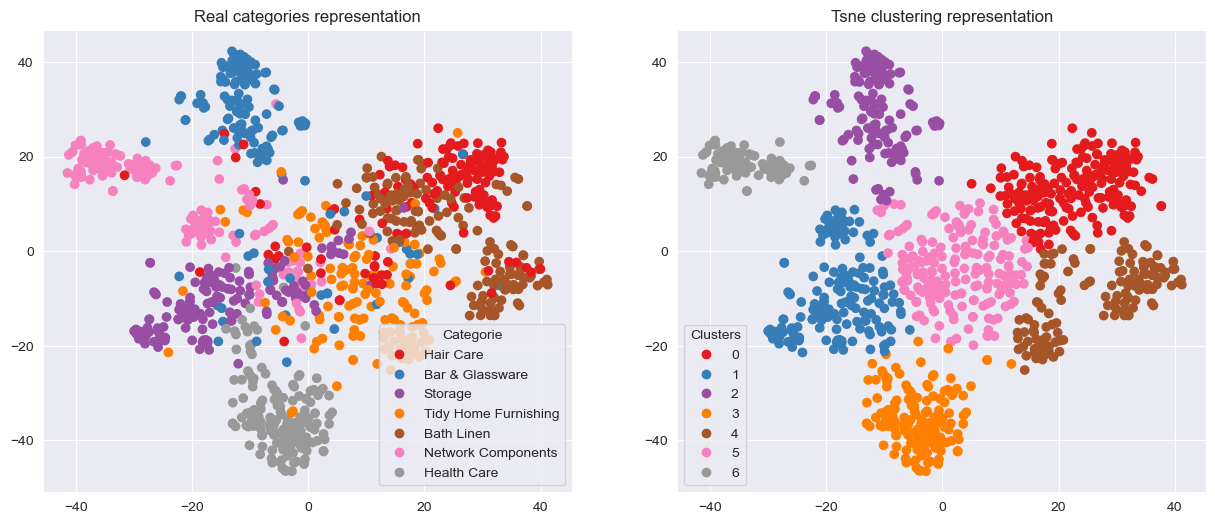

ARI :  0.44380612489719656


In [84]:
from sklearn import cluster, metrics
# Clusters creation with T-SNE
cls = cluster.KMeans(n_clusters=7)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

# Calculation of the ARI Score
label = data["label"]
ARI = metrics.adjusted_rand_score(label, cls.labels_)
print("The ARI score is: ", ARI)

# Representation of the clustering (poor) results
TSNE_visu_fct(X_tsne, label, cls.labels_, ARI)

By using the fully pretrained vgg model, the results are now way better and we manage to obtain an ARI score of 47%.
What are the best predicted classes?

In [85]:
# Confusion matrix
conf_mat = metrics.confusion_matrix(label, cls.labels_)

# Same function as in ORB 
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    
    corresp = np.argmax(conf_mat, axis=0) #this time, we assume that argmax is a more correct hypothesis because we have an overall better accuracy
    print ("Clusters correspondance : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(label, cls.labels_)
conf_mat = metrics.confusion_matrix(label, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(label, cls_labels_transform, zero_division =0))
     

Clusters correspondance :  [0 2 1 6 4 3 5]
[[111   4   1  24   8   1   1]
 [  5 117   8  14   4   1   1]
 [  1   1 109  38   0   0   1]
 [  4   1   6  74  58   0   7]
 [ 74   0   0   8  68   0   0]
 [  0  10  32  30   0  78   0]
 [  0   0  14   2   0   0 134]]

              precision    recall  f1-score   support

           0       0.57      0.74      0.64       150
           1       0.88      0.78      0.83       150
           2       0.64      0.73      0.68       150
           3       0.39      0.49      0.44       150
           4       0.49      0.45      0.47       150
           5       0.97      0.52      0.68       150
           6       0.93      0.89      0.91       150

    accuracy                           0.66      1050
   macro avg       0.70      0.66      0.66      1050
weighted avg       0.70      0.66      0.66      1050



<AxesSubplot:>

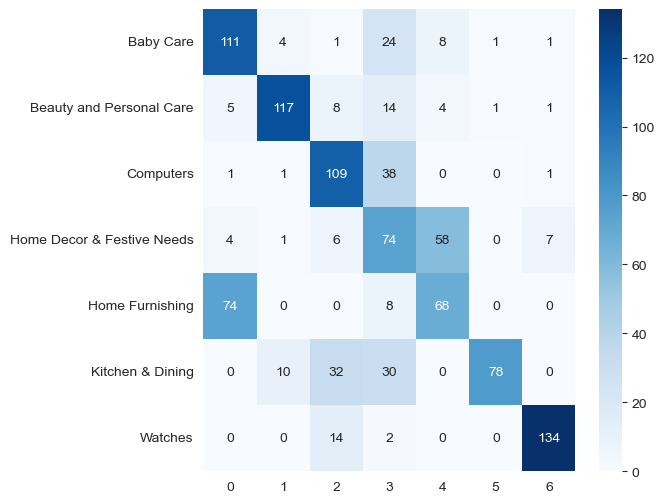

In [86]:
# Visual representation
df_cm = pd.DataFrame(conf_mat, index = [label for label in dict_classes],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,6))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')

We can be quite satisfied with this model as it's the most performing one of the overall project, also including the NLP models.
Let's give a last try to a fine-tuned model wiht only the last layer to retrain.

### VGG16 fine-tuned

In [49]:
from tensorflow.keras.utils import load_img
from keras.utils.image_utils import img_to_array
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from pickle import dump

In [50]:
# Reloading the data
data = tknzd_text[["uniq_id", "image", "cat_lvl_1"]]
data.rename(columns={"image" : "image_path",
                     "cat_lvl_1" : "label_name"}, inplace = True)

le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["label_name"])
data

C:\Users\grege\AppData\Local\Temp\ipykernel_12676\553740459.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={"image" : "image_path",
C:\Users\grege\AppData\Local\Temp\ipykernel_12676\553740459.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["label"] = le.fit_transform(data["label_name"])


,uniq_id,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


In [51]:
# Preparing the directories for easy implementation
#path = r"./Dataset_projet_pretraitement_textes_images/Flipkart/"
#
#for i in images:
#   img = load_img(path + "Images/" + str(i), target_size=(224, 224))
#   img = img.save(path + "Images/Categ" + str(int(data[data["image_path"]==str(i)]["label"])) +"/"+str(i))
#     

C:\Users\grege\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [32]:
data = data.sort_values('image_path')
data.head()

,uniq_id,image_path,label_name,label
280,009099b1f6e1e8f893ec29a7023153c4,009099b1f6e1e8f893ec29a7023153c4.jpg,Watches,6
86,0096e89cc25a8b96fb9808716406fe94,0096e89cc25a8b96fb9808716406fe94.jpg,Kitchen & Dining,5
724,00cbbc837d340fa163d11e169fbdb952,00cbbc837d340fa163d11e169fbdb952.jpg,Home Furnishing,4
820,00d84a518e0550612fcfcba3b02b6255,00d84a518e0550612fcfcba3b02b6255.jpg,Beauty and Personal Care,1
423,00e966a5049a262cfc72e6bbf68b80e7,00e966a5049a262cfc72e6bbf68b80e7.jpg,Computers,2


In [33]:
labels_list = list(data['label'])
labels_list

[6,
 5,
 4,
 1,
 2,
 2,
 2,
 5,
 1,
 5,
 5,
 1,
 2,
 2,
 3,
 3,
 4,
 3,
 4,
 4,
 6,
 0,
 1,
 6,
 5,
 4,
 5,
 2,
 3,
 1,
 1,
 6,
 6,
 6,
 3,
 4,
 0,
 5,
 0,
 0,
 3,
 3,
 4,
 1,
 3,
 1,
 5,
 5,
 3,
 0,
 5,
 5,
 5,
 2,
 5,
 6,
 5,
 1,
 5,
 4,
 5,
 3,
 0,
 5,
 4,
 6,
 4,
 6,
 6,
 5,
 0,
 3,
 5,
 4,
 2,
 1,
 1,
 0,
 1,
 6,
 2,
 6,
 4,
 5,
 6,
 4,
 6,
 1,
 3,
 4,
 6,
 3,
 1,
 3,
 1,
 0,
 6,
 3,
 1,
 3,
 6,
 2,
 5,
 1,
 1,
 1,
 1,
 1,
 6,
 6,
 2,
 1,
 6,
 5,
 2,
 3,
 5,
 2,
 3,
 5,
 6,
 3,
 4,
 0,
 0,
 5,
 6,
 1,
 0,
 3,
 4,
 1,
 6,
 2,
 5,
 0,
 0,
 4,
 1,
 2,
 2,
 3,
 3,
 5,
 0,
 2,
 3,
 4,
 4,
 4,
 2,
 2,
 6,
 5,
 6,
 0,
 3,
 2,
 3,
 1,
 6,
 5,
 4,
 0,
 2,
 0,
 6,
 1,
 1,
 1,
 3,
 6,
 5,
 4,
 3,
 3,
 5,
 3,
 3,
 6,
 0,
 2,
 3,
 0,
 0,
 0,
 6,
 5,
 0,
 0,
 2,
 4,
 5,
 6,
 3,
 2,
 3,
 3,
 6,
 6,
 4,
 6,
 1,
 3,
 5,
 2,
 5,
 5,
 6,
 0,
 1,
 0,
 4,
 1,
 2,
 6,
 0,
 1,
 5,
 0,
 5,
 3,
 3,
 0,
 3,
 1,
 5,
 6,
 2,
 0,
 5,
 4,
 0,
 0,
 0,
 1,
 5,
 4,
 4,
 4,
 6,
 3,
 6,
 3,
 3,
 6,
 3,
 6,
 4,
 1,


In [36]:
# Retraining a model without only the last fully-connected layer
import time
from tensorflow.keras.optimizers import SGD, Adam
opt = SGD(lr=0.0001, momentum=0.9) 
path = r"./Dataset_projet_pretraitement_textes_images/Flipkart/Images"

image_size = (224, 224)
batch_size = 64


train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    seed=42,
    subset="training",
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    seed=42,
    subset="validation",
    image_size=image_size,
    batch_size=batch_size,
)

epochs=7 # after training, we reached the maximal training accuracy (1) at epoch 6, so we reduced it from 10 to 7 to gain on training time.


my_model = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

flat1 = Flatten()(my_model.layers[-2].output)
class1 = Dense(4096, activation='relu')(flat1)
predictions = Dense(7, activation='softmax')(class1)

my_model = Model(inputs=my_model.input, outputs=predictions)

my_model.get_layer('block1_conv1').trainable = False
my_model.get_layer('block1_conv2').trainable = False
my_model.get_layer('block2_conv1').trainable = False
my_model.get_layer('block2_conv2').trainable = False
my_model.get_layer('block3_conv1').trainable = False
my_model.get_layer('block3_conv2').trainable = False
my_model.get_layer('block3_conv3').trainable = False
my_model.get_layer('block4_conv1').trainable = False
my_model.get_layer('block4_conv2').trainable = False
my_model.get_layer('block4_conv3').trainable = False
my_model.get_layer('block5_conv1').trainable = False
my_model.get_layer('block5_conv2').trainable = False

my_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])


start = time.time()
training = my_model.fit(train_ds,
                         epochs=epochs,
                         validation_data=val_ds
                         )

end = time.time()
duration = end - start
print("Training time : ", duration)

Found 1050 files belonging to 7 classes.
Using 840 files for training.
Found 1050 files belonging to 7 classes.
Using 210 files for validation.
Epoch 1/7
14/14 [==============================] - 159s 11s/step - loss: 8.5003 - accuracy: 0.5929 - val_loss: 6.4672 - val_accuracy: 0.7619
Epoch 2/7
14/14 [==============================] - 141s 10s/step - loss: 1.5260 - accuracy: 0.9226 - val_loss: 5.9078 - val_accuracy: 0.8190
Epoch 3/7
14/14 [==============================] - 163s 12s/step - loss: 0.4208 - accuracy: 0.9810 - val_loss: 5.8046 - val_accuracy: 0.7857
Epoch 4/7
14/14 [==============================] - 129s 9s/step - loss: 0.0217 - accuracy: 0.9929 - val_loss: 5.6790 - val_accuracy: 0.7952
Epoch 5/7
14/14 [==============================] - 129s 9s/step - loss: 0.0020 - accuracy: 0.9988 - val_loss: 5.7636 - val_accuracy: 0.8000
Epoch 6/7
14/14 [==============================] - 127s 9s/step - loss: 2.6446e-05 - accuracy: 1.0000 - val_loss: 5.7610 - val_accuracy: 0.8000
Epoch 7/7

In [37]:
my_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [52]:
features_fine_tuning_matrix = np.zeros((1, 7))

#model = Model(inputs=my_model.inputs, outputs=my_model.layers[-1].output)

for i in preprocessed_images:
  features_fine_tuning = my_model.predict(i)
  features_fine_tuning_matrix = np.append(features_fine_tuning_matrix, features_fine_tuning, axis=0)

features_fine_tuning_matrix = np.delete(features_fine_tuning_matrix, 0, 0)

1/1 [==============================] - 0s 201ms/step


1/1 [==============================] - 0s 194ms/step


1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 202ms/step


In [53]:
from sklearn import manifold, decomposition
# We first use a PCA to improve T-SNE and its training time
print("Dimension of dataset before PCA : ", features_fine_tuning_matrix.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(features_fine_tuning_matrix)
print("Dimension of dataset after PCA : ", feat_pca.shape)


# Second, we run a T-SNE with to the PCA results
# Tsne perplexity calculation (from https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868)
perp_ = pow(feat_pca.shape[0], (1/2))

tsne = manifold.TSNE(n_components=2, perplexity=perp_, 
                     n_iter=2000, init='random')
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]
print(df_tsne.shape)

Dimension of dataset before PCA :  (1050, 7)
Dimension of dataset after PCA :  (1050, 6)


C:\Users\grege\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


(1050, 4)
The ARI score is:  0.8712431444949759


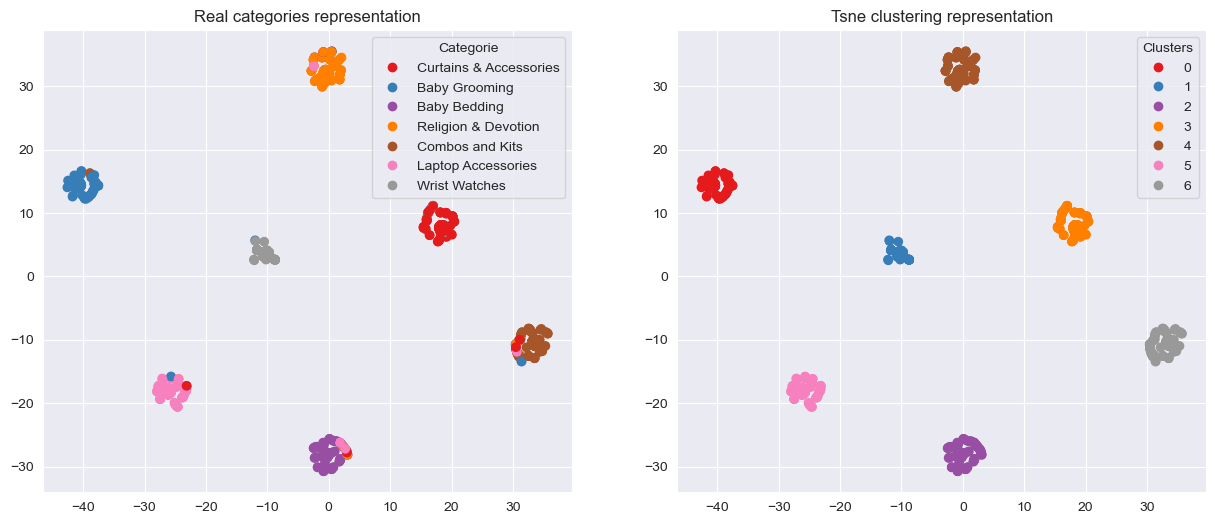

ARI :  0.8712431444949759


In [54]:
from sklearn import cluster, metrics
# Clusters creation with T-SNE
cls = cluster.KMeans(n_clusters=7)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

# Calculation of the ARI Score
label = data["label"]
ARI = metrics.adjusted_rand_score(label, cls.labels_)
print("The ARI score is: ", ARI)

# Representation of the clustering (poor) results
TSNE_visu_fct(X_tsne, label, cls.labels_, ARI)

In [55]:
# Confusion matrix
conf_mat = metrics.confusion_matrix(label, cls.labels_)

# Same function as in ORB 
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    
    corresp = np.argmax(conf_mat, axis=0) #this time, we assume that argmax is a more correct hypothesis because we have an overall better accuracy
    print ("Clusters correspondance : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(label, cls.labels_)
conf_mat = metrics.confusion_matrix(label, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(label, cls_labels_transform, zero_division =0))

Clusters correspondance :  [1 6 2 0 3 5 4]
[[138   0   1   3   7   1   0]
 [  3 136   0   5   4   1   1]
 [  2   0 146   1   0   1   0]
 [  2   0   3 139   3   2   1]
 [  7   1   0   0 142   0   0]
 [  1   1   3   2   1 142   0]
 [  1   0   0   1   1   0 147]]

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       150
           1       0.99      0.91      0.94       150
           2       0.95      0.97      0.96       150
           3       0.92      0.93      0.92       150
           4       0.90      0.95      0.92       150
           5       0.97      0.95      0.96       150
           6       0.99      0.98      0.98       150

    accuracy                           0.94      1050
   macro avg       0.94      0.94      0.94      1050
weighted avg       0.94      0.94      0.94      1050



In [57]:
# Associating classes to labels in a dict
classes = le.classes_
values = le.transform(le.classes_)
dict_classes = dict(zip(classes, values))
print(dict_classes)

{'Baby Care': 0, 'Beauty and Personal Care': 1, 'Computers': 2, 'Home Decor & Festive Needs': 3, 'Home Furnishing': 4, 'Kitchen & Dining': 5, 'Watches': 6}


<AxesSubplot:>

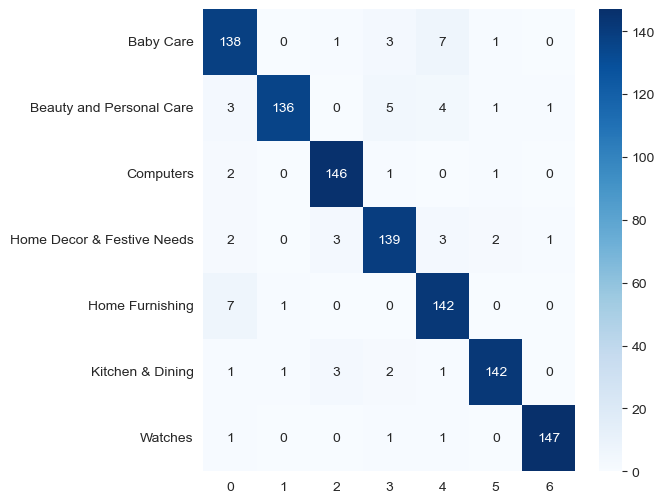

In [58]:
# Visual representation
df_cm = pd.DataFrame(conf_mat, index = [label for label in dict_classes],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,6))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')

With a proper fine-tuning, we obtain a remarquable score of 88% Accuracy.

All classes are remarquably predicted, with very little differences between each. 